In [1]:
import numpy as np
import matplotlib.pyplot as plt


from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, log_loss, accuracy_score

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Dense,Flatten,GlobalAveragePooling2D,Conv2D,MaxPooling2D,Activation,Dropout


import warnings
warnings.filterwarnings('ignore')

from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, CarliniLInfMethod, DeepFool
from art.attacks.evasion import FeatureAdversariesTensorFlowV2
from art.estimators.classification import TensorFlowV2Classifier
if tf.__version__[0] != '2':
    raise ImportError('This notebook requires TensorFlow v2.')

In [2]:
lfw_dataset=fetch_lfw_people(min_faces_per_person=100)

print(lfw_dataset.images.shape)
print(lfw_dataset.data.shape)
print(lfw_dataset.target_names.shape)
print(lfw_dataset.target.shape)

Name = lfw_dataset.target_names

print(Name)
print(len(Name))

N=[]
for i in range(len(Name)):
    N+=[i]
    
mapping=dict(zip(Name,N)) 
reverse_mapping=dict(zip(N,Name)) 

def mapper(value):
    return reverse_mapping[value]

X0=lfw_dataset.images
y=lfw_dataset.target

print(X0.shape)
X=X0.reshape(-1,62,47,1)
print(X.shape)

dataset=[]
testset=[]
t=0
for Xi,yi in zip(X,y):
    img=Xi/255.0
    if t<=200:
        dataset.append([img,yi])
    else:   
        testset.append([img,yi])
    t+=1

data,labels0=zip(*dataset)
test,tlabels0=zip(*testset)

labels1=to_categorical(labels0)
data=np.array(data)
labels=np.array(labels1)

tlabels1=to_categorical(tlabels0)
test=np.array(test)
tlabels=np.array(tlabels1)

# trainx,testx,trainy,testy=train_test_split(data,labels,test_size=0.2,random_state=44)
trainx,testx,trainy,testy=train_test_split(data,labels,test_size=0.2,random_state=1)

x_train = trainx.astype(np.float32)
x_test = testx.astype(np.float32)
y_train = trainy.astype(np.float32)
y_test = testy.astype(np.float32)

print(trainx.shape)
print(testx.shape)
print(trainy.shape)
print(testy.shape)

(1140, 62, 47)
(1140, 2914)
(5,)
(1140,)
['Colin Powell' 'Donald Rumsfeld' 'George W Bush' 'Gerhard Schroeder'
 'Tony Blair']
5
(1140, 62, 47)
(1140, 62, 47, 1)
(160, 62, 47, 1)
(41, 62, 47, 1)
(160, 5)
(41, 5)


In [3]:
# datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=20,zoom_range=0.2,
#                     width_shift_range=0.2,height_shift_range=0.2,shear_range=0.1,fill_mode="nearest")

model = Sequential()

model.add(Conv2D(32,(3,3), input_shape=(62,47,1), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32,(3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=5, activation='softmax'))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 60, 45, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 22, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 20, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 10, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 4480)              0         
                                                                 
 dense (Dense)               (None, 512)               2

In [4]:
model.fit(trainx,trainy, validation_data=(testx,testy),epochs=1000, batch_size=32)

Train on 160 samples, validate on 41 samples
Metal device set to: Apple M1


2023-05-17 20:45:18.283884: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-17 20:45:18.284417: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-05-17 20:45:18.313575: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-17 20:45:18.315109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-17 20:45:18.371845: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch 1/1000


2023-05-17 20:45:18.493838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-17 20:45:18.500559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - 1s 3ms/sample - loss: 1.4949 - accuracy: 0.4938 - val_loss: 1.5238 - val_accuracy: 0.4390
Epoch 2/1000


2023-05-17 20:45:18.924118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


160/160 [==============================] - 0s 1ms/sample - loss: 1.4226 - accuracy: 0.4750 - val_loss: 1.4979 - val_accuracy: 0.4390
Epoch 3/1000
160/160 [==============================] - 0s 1ms/sample - loss: 1.4001 - accuracy: 0.4750 - val_loss: 1.4578 - val_accuracy: 0.4390
Epoch 4/1000
160/160 [==============================] - 0s 1ms/sample - loss: 1.3905 - accuracy: 0.4750 - val_loss: 1.4338 - val_accuracy: 0.4390
Epoch 5/1000
160/160 [==============================] - 0s 1ms/sample - loss: 1.3598 - accuracy: 0.4750 - val_loss: 1.4179 - val_accuracy: 0.4390
Epoch 6/1000
160/160 [==============================] - 0s 1ms/sample - loss: 1.2861 - accuracy: 0.4750 - val_loss: 1.4759 - val_accuracy: 0.4390
Epoch 7/1000
160/160 [==============================] - 0s 1ms/sample - loss: 1.2465 - accuracy: 0.4875 - val_loss: 1.3291 - val_accuracy: 0.4878
Epoch 8/1000
160/160 [==============================] - 0s 1ms/sample - loss: 1.1375 - accuracy: 0.5875 - val_loss: 1.2560 - val_accuracy

KeyboardInterrupt: 

In [30]:
loss_test, accuracy_test = model.evaluate(x_test, y_test)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy on test data: 85.37%


In [5]:
# model.save("VGG_model_87.pth")
model = keras.models.load_model("VGG_model_87.pth")

Metal device set to: Apple M1


2023-05-17 21:01:58.014056: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-17 21:01:58.014202: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-05-17 21:01:58.033366: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-17 21:01:58.034681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-17 21:01:58.068151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [7]:
classifier = KerasClassifier(model=model, clip_values=(0, 1))

In [8]:
# attack_fgsm = FastGradientMethod(estimator=classifier, eps=10/255)
eps = np.linspace(1e-4, 20/255, 20)
# eps = [10/255]
accuracyFGSM = []
for _eps in eps:
    attack_fgsm = FastGradientMethod(estimator=classifier, eps=_eps)
    x_test_adv = attack_fgsm.generate(x_test)
    loss_test, accuracy_test = model.evaluate(x_test_adv, y_test)
    accuracyFGSM.append(accuracy_test)
    print("eps: {}, accuracy: {}".format(_eps, accuracy_test))


2023-05-17 21:02:05.139042: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-17 21:02:05.242058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


eps: 0.0001, accuracy: 0.878048837184906
eps: 0.004222703818369453, accuracy: 0.7804878354072571
eps: 0.008345407636738906, accuracy: 0.5609756112098694
eps: 0.012468111455108358, accuracy: 0.41463416814804077
eps: 0.01659081527347781, accuracy: 0.39024391770362854
eps: 0.020713519091847266, accuracy: 0.3658536672592163
eps: 0.024836222910216716, accuracy: 0.3414634168148041
eps: 0.02895892672858617, accuracy: 0.31707319617271423
eps: 0.03308163054695563, accuracy: 0.292682945728302
eps: 0.03720433436532508, accuracy: 0.26829269528388977
eps: 0.041327038183694535, accuracy: 0.24390244483947754
eps: 0.04544974200206399, accuracy: 0.2195122092962265
eps: 0.049572445820433436, accuracy: 0.17073170840740204
eps: 0.05369514963880289, accuracy: 0.146341472864151
eps: 0.057817853457172344, accuracy: 0.146341472864151
eps: 0.0619405572755418, accuracy: 0.12195122241973877
eps: 0.06606326109391125, accuracy: 0.12195122241973877
eps: 0.0701859649122807, accuracy: 0.12195122241973877
eps: 0.07430

In [9]:
x_test_adv = attack_fgsm.generate(x_test)

In [10]:
loss_test, accuracy_test = model.evaluate(x_test_adv, y_test)
perturbation = np.mean(np.abs((x_test_adv - x_test)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on adversarial test data: 12.20%
Average perturbation: 0.08


In [11]:
1/255

0.00392156862745098

Text(0, 0.5, 'accuracy')

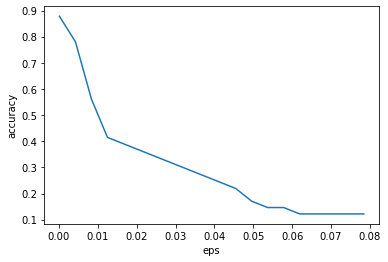

In [12]:
plt.plot(eps, accuracyFGSM)
plt.xlabel("eps")
plt.ylabel("accuracy")
# plt.savefig("FGSM.png", dpi=300, bbox_inches='tight')

In [31]:
def plot_gallery(images, titles, h=62, w=47, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i+1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(Name[np.argmax(titles[i])], size=12)
        plt.xticks(())
        plt.yticks(())

def plot_image(image, title):
    """Helper function to plot a gallery of portraits"""
    plt.matshow(image, cmap=plt.cm.gray)
    plt.title(Name[np.argmax(title)], size=12)
    plt.xticks(())
    plt.yticks(())

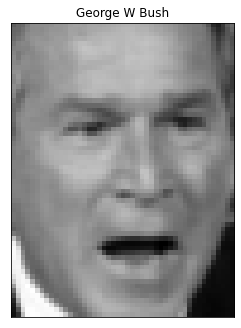

In [18]:
k = 1
plot_image(testx[k, :], testy[k])

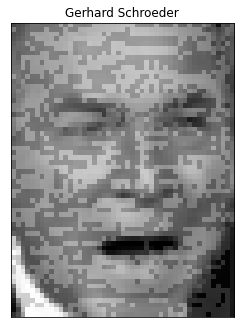

In [19]:
plot_image(x_test_adv[k, :], model.predict(x_test_adv)[k])

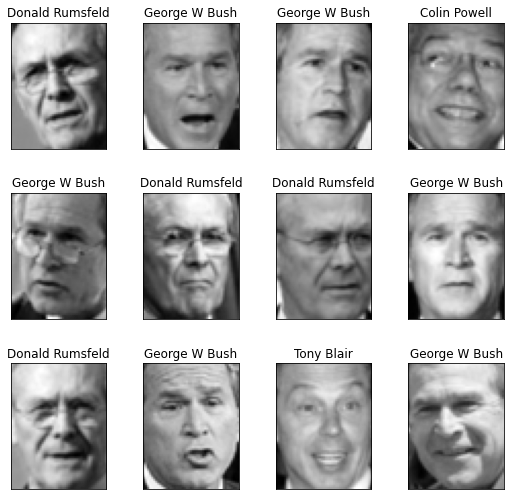

In [24]:
plot_gallery(testx, testy)

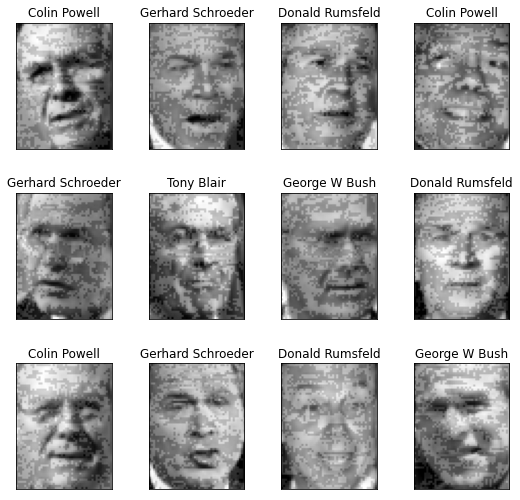

In [25]:
plot_gallery(x_test_adv, model.predict(x_test_adv))

In [14]:
# attack_cw = CarliniLInfMethod(classifier=classifier,
#                               max_iter=100,
#                               learning_rate=0.01,
#                               initial_const=1e0,
#                               largest_const=2e0)
attack_fgsm = FastGradientMethod(estimator=classifier, eps=3/255)
# x_test_adv = attack_cw.generate(x_test)
# x_train_adv = attack_cw.generate(x_train)
x_train_adv = attack_fgsm.generate(x_train)

In [15]:
# loss_test, accuracy_test = model.evaluate(x_test_adv, y_test)
# perturbation = np.mean(np.abs((x_test_adv - x_test)))
# print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
# print('Average perturbation: {:4.2f}'.format(perturbation))

loss_test, accuracy_test = model.evaluate(x_train_adv, y_train)
perturbation = np.mean(np.abs((x_train_adv - x_train)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on adversarial test data: 90.62%
Average perturbation: 0.01


In [16]:
# plot_gallery(testx, testy)

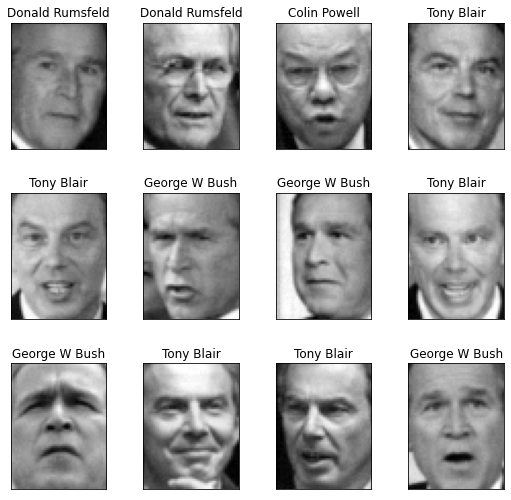

In [17]:
plot_gallery(x_train_adv, model.predict(x_train_adv))

In [18]:
np.append(x_train, x_train_adv[::2, :]).reshape(-1, 62, 47, 1).shape

(240, 62, 47, 1)

In [19]:
# attack_cw = CarliniLInfMethod(classifier=classifier,
#                               max_iter=100,
#                               learning_rate=0.01,
#                               initial_const=1e0,
#                               largest_const=2e0)
x_adv = attack_fgsm.generate(x_train[::5, :])
y_adv = model.predict(x_adv)

In [20]:
x_adv.shape, y_adv.shape, x_adv.shape, y_adv.shape

((32, 62, 47, 1), (32, 5), (32, 62, 47, 1), (32, 5))

In [21]:
loss_test, accuracy_test = model.evaluate(x_adv, y_train[::5, :])
perturbation = np.mean(np.abs((x_adv - x_train[::5, :])))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on adversarial test data: 87.50%
Average perturbation: 0.01


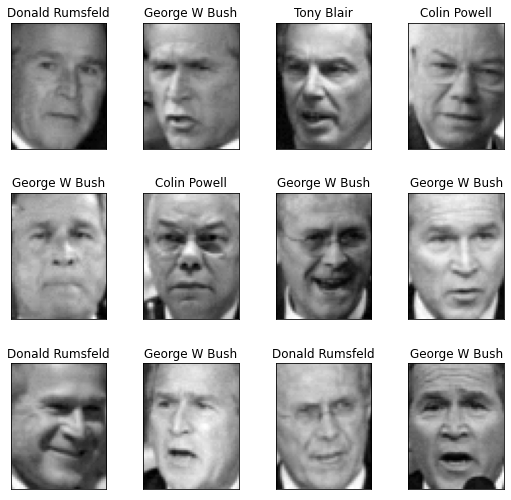

In [22]:
plot_gallery(x_adv, y_adv)

In [23]:
x_add_adv_data = np.append(x_train, x_adv).reshape(-1, 62, 47, 1)
y_add_adv_data = np.append(y_train, model.predict(x_adv)).reshape(-1, 5)
x_add_adv_data.shape, y_add_adv_data.shape

((192, 62, 47, 1), (192, 5))

In [24]:
model.fit(x_add_adv_data,y_add_adv_data, validation_data=(testx,testy),epochs=100, batch_size=32)

Train on 192 samples, validate on 41 samples
Epoch 1/100


2023-05-17 21:02:34.828737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-17 21:02:34.862748: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-05-17 21:02:34.901877: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


192/192 [==============================] - 0s 2ms/sample - loss: 0.5972 - accuracy: 0.9219 - val_loss: 5.4324 - val_accuracy: 0.5366
Epoch 2/100
192/192 [==============================] - 0s 1ms/sample - loss: 0.6014 - accuracy: 0.8906 - val_loss: 1.3592 - val_accuracy: 0.6341
Epoch 3/100
192/192 [==============================] - 0s 966us/sample - loss: 0.1952 - accuracy: 0.9427 - val_loss: 0.6300 - val_accuracy: 0.8537
Epoch 4/100
192/192 [==============================] - 0s 1ms/sample - loss: 0.1721 - accuracy: 0.9583 - val_loss: 0.6340 - val_accuracy: 0.7805
Epoch 5/100
192/192 [==============================] - 0s 1ms/sample - loss: 0.1262 - accuracy: 0.9635 - val_loss: 0.6634 - val_accuracy: 0.7805
Epoch 6/100
192/192 [==============================] - 0s 2ms/sample - loss: 0.0692 - accuracy: 0.9896 - val_loss: 0.6586 - val_accuracy: 0.7805
Epoch 7/100
192/192 [==============================] - 0s 1ms/sample - loss: 0.0484 - accuracy: 0.9948 - val_loss: 0.6615 - val_accuracy: 0.

In [25]:
x_adv.shape, y_train[::5, :].shape

((32, 62, 47, 1), (32, 5))

In [26]:
loss_test, accuracy_test = model.evaluate(x_adv, y_train[::5, :])
perturbation = np.mean(np.abs((x_adv - x_train[::5, :])))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on adversarial test data: 90.62%
Average perturbation: 0.01


In [27]:
loss_test, accuracy_test = model.evaluate(x_test, y_test)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy on test data: 85.37%


In [28]:
# attack_fgsm = FastGradientMethod(estimator=classifier, eps=10/255)
eps = np.linspace(1e-4, 20/255, 20)
# eps = [1/255]
accuracyFGSM_after = []
for _eps in eps:
    attack_fgsm = FastGradientMethod(estimator=classifier, eps=_eps)
    x_test_adv = attack_fgsm.generate(x_test)
    loss_test, accuracy_test = model.evaluate(x_test_adv, y_test)
    accuracyFGSM_after.append(accuracy_test)
    print("eps: {}, accuracy: {}".format(_eps, accuracy_test))

eps: 0.0001, accuracy: 0.8536585569381714
eps: 0.004222703818369453, accuracy: 0.7073171138763428
eps: 0.008345407636738906, accuracy: 0.585365891456604
eps: 0.012468111455108358, accuracy: 0.4878048896789551
eps: 0.01659081527347781, accuracy: 0.39024391770362854
eps: 0.020713519091847266, accuracy: 0.292682945728302
eps: 0.024836222910216716, accuracy: 0.2195122092962265
eps: 0.02895892672858617, accuracy: 0.146341472864151
eps: 0.03308163054695563, accuracy: 0.12195122241973877
eps: 0.03720433436532508, accuracy: 0.12195122241973877
eps: 0.041327038183694535, accuracy: 0.12195122241973877
eps: 0.04544974200206399, accuracy: 0.12195122241973877
eps: 0.049572445820433436, accuracy: 0.12195122241973877
eps: 0.05369514963880289, accuracy: 0.12195122241973877
eps: 0.057817853457172344, accuracy: 0.09756097942590714
eps: 0.0619405572755418, accuracy: 0.09756097942590714
eps: 0.06606326109391125, accuracy: 0.09756097942590714
eps: 0.0701859649122807, accuracy: 0.09756097942590714
eps: 0.07

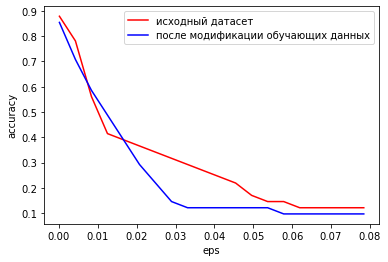

In [29]:
plt.plot(eps, accuracyFGSM, color="r", label="исходный датасет")
plt.plot(eps, accuracyFGSM_after, color="b", label="после модификации обучающих данных")

plt.xlabel("eps")
plt.ylabel("accuracy")
plt.legend()
# plt.savefig("FGSM_test.png", dpi=300, bbox_inches='tight')

In [52]:
model.fit(trainx,trainy, validation_data=(testx,testy),epochs=100, batch_size=32)

Train on 160 samples, validate on 41 samples
Epoch 1/100
160/160 [==============================] - 0s 1ms/sample - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.8602 - val_accuracy: 0.8293
Epoch 2/100
160/160 [==============================] - 0s 693us/sample - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.8805 - val_accuracy: 0.8537
Epoch 3/100
160/160 [==============================] - 0s 660us/sample - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.8930 - val_accuracy: 0.7805
Epoch 4/100
160/160 [==============================] - 0s 717us/sample - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.9117 - val_accuracy: 0.7805
Epoch 5/100
160/160 [==============================] - 0s 811us/sample - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.9289 - val_accuracy: 0.7805
Epoch 6/100
160/160 [==============================] - 0s 862us/sample - loss: 9.4489e-04 - accuracy: 1.0000 - val_loss: 0.9356 - val_accuracy: 0.7805
Epoch 7/100
160/160 [==============================] - 0s 761us/sample 

Epoch 55/100
160/160 [==============================] - 0s 750us/sample - loss: 2.9906e-04 - accuracy: 1.0000 - val_loss: 0.9961 - val_accuracy: 0.7805
Epoch 56/100
160/160 [==============================] - 0s 757us/sample - loss: 2.9556e-04 - accuracy: 1.0000 - val_loss: 0.9967 - val_accuracy: 0.7805
Epoch 57/100
160/160 [==============================] - 0s 700us/sample - loss: 2.9159e-04 - accuracy: 1.0000 - val_loss: 0.9983 - val_accuracy: 0.7805
Epoch 58/100
160/160 [==============================] - 0s 673us/sample - loss: 2.8794e-04 - accuracy: 1.0000 - val_loss: 0.9996 - val_accuracy: 0.7805
Epoch 59/100
160/160 [==============================] - 0s 677us/sample - loss: 2.8441e-04 - accuracy: 1.0000 - val_loss: 1.0003 - val_accuracy: 0.7805
Epoch 60/100
160/160 [==============================] - 0s 667us/sample - loss: 2.8053e-04 - accuracy: 1.0000 - val_loss: 1.0010 - val_accuracy: 0.7805
Epoch 61/100
160/160 [==============================] - 0s 757us/sample - loss: 2.7710e-

In [ ]:
loss_test, accuracy_test = model.evaluate(x_test, y_test)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

In [ ]:
attack = DeepFool(classifier,
                 epsilon=1/255,
                 )

# Применение атаки на тестовом наборе данных
x_test_adv = attack.generate(x_test)

# Оценка точности классификатора на защищенных примерах
loss_test, accuracy_test = model.evaluate(x_test_adv, y_test)
perturbation = np.mean(np.abs((x_test_adv - x_test)))
print('Accuracy on adversarial test data: {:4.2f}%'.format(accuracy_test * 100))
print('Average perturbation: {:4.2f}'.format(perturbation))